In [1]:
#Bibliotheken einbinden
import pandas as pd
from pathlib import Path
from numpy.polynomial.polynomial import polyfit
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.dates as mdates

# Definieren von Sensorenreihenfolge, -höhe, Bezeichnung in Exceltabellen
sensoren_gesamt = [
    "TL", "T1", "T2", "T3", "T4", "T5", "T6", "T7", "T8", "T9",
    "T10", "T11", "T12", "T13", "T14", "T15", "T16", "T17", "T18", "T19"
]

# Excelbezeichnung (Reihenfolge identisch wie Skizzenliste)
sensoren_excel = [
    "T11", "T6", "T9", "T4", "T15", "T14", "T10", "T17", "T12", "T13",
    "T3", "T19", "T7", "T8", "T18", "T20", "T16", "T1", "T2", "T5"
]

# Umwandeln in Dictionary
skizze_to_excel = dict(zip(sensoren_gesamt, sensoren_excel))
excel_to_skizze = dict(zip(sensoren_excel, sensoren_gesamt))

#Sensoren im Teilquerschnitt nach Skizzenbezeichnung
sensoren_aussen = ["T4", "T5", "T6", "T10", "T11", "T12", "T16", "T18"] # ohne T7-9 (zu extreme Werte)
sensoren_innen = ["T1", "T2", "T3", "T13", "T14", "T15", "T17", "T19"]  # ohne T7-9 (zu extreme Werte)
sensoren_oben = ["T7", "T8", "T9"]
sensoren_links_innen = ["T1", "T2", "T3", "T19"]
sensoren_links_aussen = ["T4", "T5", "T6", "T18"]
sensoren_rechts_innen   = ["T13", "T14", "T15", "T17"]
sensoren_rechts_aussen  = ["T10", "T11", "T12", "T16"]
sensoren_gesamt_ohneOben = [
    s for s in sensoren_gesamt
    if s not in sensoren_oben
]
sensoren_links = sensoren_links_innen + sensoren_links_aussen
sensoren_rechts = sensoren_rechts_innen + sensoren_rechts_aussen

#Sensorhöhen nach Skizzenbezeichnung (UK Stege als 0,00 definiert)
sensor_hoehen = {
"TL": 0.25, #TL
"T1": 1.25, "T2": 0.75, "T3": 0.25, "T4": 0.25, "T5": 0.75, "T6": 1.25, #T1-6
"T7": 1.71, "T8": 1.81, "T9": 1.91, #T7-9
"T10": 1.25, "T11": 0.75, "T12": 0.25, "T13": 0.25, "T14": 0.75, "T15": 1.25, #T10-15
"T16": 1.5, "T17": 1.6, #T16-17
"T18": 1.5, "T19": 1.6, #T18-19
}

# Hilfsfunktion: Daten laden (in Skizzenbezeichnung)
def lade_df(sensorliste, start, ende):
    excel_spalten = [skizze_to_excel[s] for s in sensorliste]
    df = gesamt_df.loc[start:ende, excel_spalten]
    df = df.rename(columns=excel_to_skizze)
    return df[sensorliste]

# Hilfsfunktion: beliebige Liste in Skizzenbezeichnung über die Höhe sortieren
def sensoren_nach_hoehe(sensorliste):
    return sorted(sensorliste, key=lambda s: sensor_hoehen[s])

# Hilfsfunktion: Gradienten berechnen
def berechne_gradient(df, sensorliste):

    sensorliste_sortiert = sensoren_nach_hoehe(sensorliste)
    hoehen = np.array([sensor_hoehen[s] for s in sensorliste_sortiert])
    
    werte = df[sensorliste_sortiert].to_numpy()
    
    gradients = np.full(len(df), np.nan)
    
    # Über alle Zeitpunkte iterieren
    for i in range(werte.shape[0]):
        
        temperaturen = werte[i]
        gueltig = ~np.isnan(temperaturen)
        
        if np.sum(gueltig) >= 2:
            steigung, _ = np.polyfit(
                hoehen[gueltig],
                temperaturen[gueltig],
                1
            )
            gradients[i] = steigung
    
    return pd.Series(gradients, index=df.index)

In [2]:
datein = Path.cwd().glob("*.csv") #Dateipfad für csv-Dateien im selben Ordner wie Skript

cols = ["number", "date", "time"] + [f"T{i}" for i in range(1, 21)] #Kopfzeile erstellen, ersetzt die der csv-Datein

dfs = []

for i in datein:
    try:
        df = pd.read_csv(
            i,
            sep=";",
            encoding="latin1",
            skiprows=2,
            names=cols,
            usecols=range(23),
            on_bad_lines="skip"   # skippen von fehlerbehafteten Zellen
        )
        dfs.append(df)
    except pd.errors.EmptyDataError:
        continue

gesamt_df = pd.concat(dfs, ignore_index=True)

#COdeblock nötig zum bereinigen der dezimaltrenner. Beim Einlesen der CSV-Datein hat 'decimal=","' nicht zuverlässig funktioniert.
#Daher werden hier alle , durch . ersetzt und der String als Zahl abgespeichert

temp_spalten = gesamt_df.filter(like="T").columns #erstellen von einer Liste der Temperaturspalten


gesamt_df[temp_spalten] = ( #Ersetzen
    gesamt_df[temp_spalten]
    .astype(str)
    .replace(",", ".", regex = True)
    .apply(pd.to_numeric, errors="coerce")
)

#Codeblock zum erstellen eines Indexes für alle Zeilen aus spalten "Date" und "Time"

gesamt_df["datetime"] = pd.to_datetime(
    gesamt_df["date"] + " " + gesamt_df["time"],
    format="%d.%m.%Y %H:%M:%S"
)


gesamt_df = gesamt_df.set_index("datetime") #"datetime" als index setzen
gesamt_df = gesamt_df.sort_index() #Dataframe nach "datetime" sortieren

In [3]:
# Plot der Temperaturdifferenzen zu TL
def vergleich_sensoren_TL(start, ende):
    # Sensordaten in Skizzenreihenfolge holen
    werte=lade_df(sensoren_gesamt, start,ende)
    
    # DataFrame mit Skizzenbezeichnungen erzeugen
    df_skizze = pd.DataFrame(
        werte,
        index=gesamt_df.index,
        columns=sensoren_gesamt
    )
    
    # Temperaturdifferenzen relativ zu TL
    df_diff = df_skizze.sub(df_skizze["TL"], axis=0)
    
    df_diff.loc[start:ende].plot(
        figsize=(14, 6),
        title="Temperaturdifferenzen relativ zu TL",
    )
    
    plt.ylabel("ΔT [°C]")
    plt.xlabel("Zeit")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

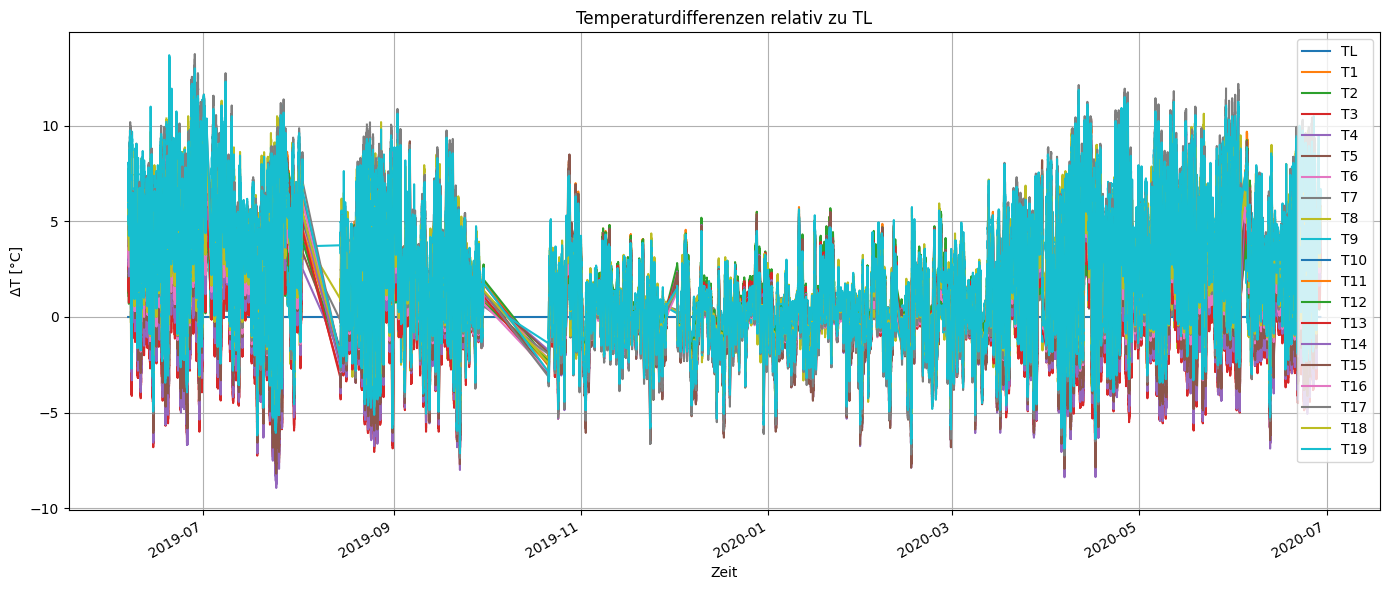

In [4]:
vergleich_sensoren_TL("2019-06-06","2020-06-28")

In [5]:
def plot_mitteltemperaturen(start, ende):
    """
    Plottet mittlere absolute Sensortemperaturen über der Höhe.
    
    - linke Sensoren  : grün
    - rechte Sensoren : lila
    - TL + T7–T9      : orange
    """
    
    # Hübsche Farben
    farben = {
        "links":  "#2ca02c",   # grün
        "rechts": "#9467bd",   # lila
        "oben":"#ff7f0e"    # orange
    }

    # Daten laden
    df_skizze = lade_df(sensoren_gesamt, start, ende)
    mittelwerte = df_skizze.mean()

    # Plot
    plt.figure(figsize=(6, 9))

    def plot_gruppe(sensorliste, farbe, label):
        first = True
        for s in sensorliste:
            if s in mittelwerte.index:
                plt.scatter(
                    mittelwerte[s],
                    sensor_hoehen[s],
                    color=farbe,
                    s=60,
                    label=label if first else None
                )
                plt.text(
                    mittelwerte[s] + 0.05,
                    sensor_hoehen[s] + 0.03,
                    s,
                    fontsize=9,
                    va="center"
                )
                first = False

    plot_gruppe(sensoren_links,   farben["links"],   "linker Teilquerschnitt")
    plot_gruppe(sensoren_rechts,  farben["rechts"],  "rechter Teilquerschnitt")
    plot_gruppe(sensoren_oben, farben["oben"], "obere Sensoren")


    # Achsen & Layout
    plt.xlabel("Temperatur [°C]")
    plt.ylabel("Höhe z [m]")
    plt.grid(True)
    plt.legend()
    plt.title("Mittlere Sensortemperaturen\n{start} bis {ende}")
    plt.tight_layout()
    plt.show()


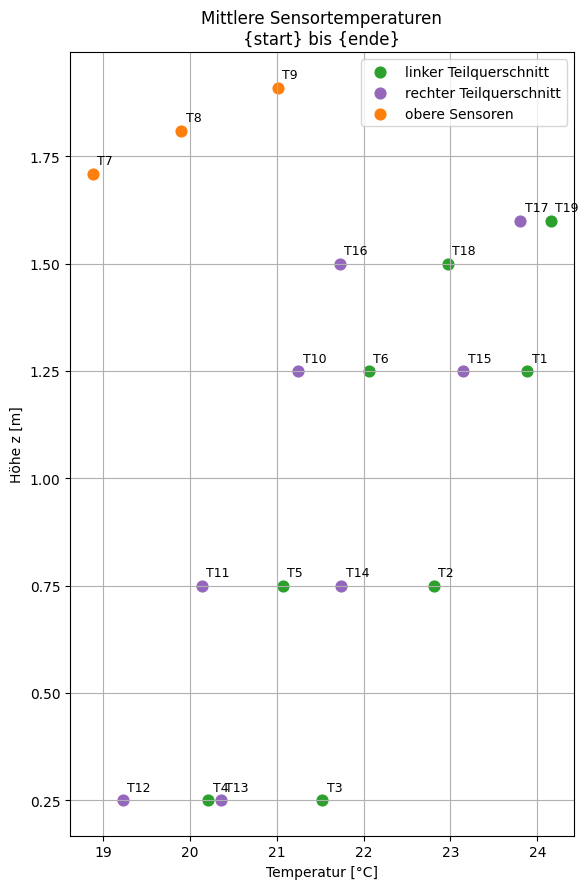

In [6]:
plot_mitteltemperaturen(
    "2019-06-06 11:00",
    "2019-06-06 12:00",
)


In [7]:
def plot_temperatur_heatmap(start, ende):
    """
    Plottet vereinheitlichte Temperatur-Heatmaps:
    1) Gesamtquerschnitt absolut (nach Höhe sortiert)
    2) ΔT linker Teilquerschnitt relativ zum Gesamt
    3) ΔT rechter Teilquerschnitt relativ zum Gesamt
    4) Gesamtquerschnitt relativ zu TL
    """

    df_gesamt = lade_df(sensoren_gesamt, start, ende)
    df_links  = lade_df(sensoren_links, start, ende)
    df_rechts = lade_df(sensoren_rechts, start, ende)


    # Colormaps

    cmap_abs = mcolors.LinearSegmentedColormap.from_list(
        "abs",
        ["black", "darkblue", "turquoise", "silver", "yellow", "red"]
    )

    cmap_delta = mcolors.LinearSegmentedColormap.from_list(
        "delta",
        ["darkblue", "blue", "white", "orange", "red"]
    )


    # Zeitachse
    xticks = np.linspace(0, len(df_gesamt.index) - 1, 10)
    xtick_labels = [
        df_gesamt.index[int(i)].strftime("%d.%m.%Y %H:%M")
        for i in xticks
    ]

    # 1. Heatmap – Gesamt absolut (nach Höhe sortiert)
    df_abs = df_gesamt[sensoren_nach_hoehe]

    plt.figure(figsize=(14, 6))
    im = plt.imshow(df_abs.T, aspect="auto", origin="lower", cmap=cmap_abs)
    plt.colorbar(im, label="Temperatur [°C]")

    sensoren_nach_hoehe_gesamt = sensoren_nach_hoehe(sensoren_gesamt)
    plt.yticks(
        np.arange(len(sensoren_nach_hoehe_gesamt)),
        [f"{s} (z={sensor_hoehen[s]:.2f} m)" for s in sensoren_nach_hoehe_gesamt]
    )
    plt.xticks(xticks, xtick_labels, rotation=45)

    plt.xlabel("Zeit")
    plt.ylabel("Sensor")
    plt.title("absolute Temperaturen im Gesamtquerschnitt")
    plt.tight_layout()
    plt.show()

    gesamt_mittel = df_gesamt.mean(axis=1)

    # 2. Heatmap – Gesamt relativ zu TL
    df_rel_tl = df_gesamt.sub(df_gesamt["TL"], axis=0)
    vmax = np.nanmax(np.abs(df_rel_tl.values))

    plt.figure(figsize=(14, 6))
    im = plt.imshow(
        df_rel_tl.T,
        aspect="auto",
        origin="lower",
        cmap=cmap_delta,
        vmin=-vmax,
        vmax=vmax
    )
    plt.colorbar(im, label="ΔT relativ zu TL [°C]")

    plt.yticks(
        np.arange(len(df_rel_tl.columns)),
        [f"{s} (z={sensor_hoehen[s]:.2f} m)" for s in df_rel_tl.columns]
    )
    plt.xticks(xticks, xtick_labels, rotation=45)

    plt.xlabel("Zeit")
    plt.ylabel("Sensor")
    plt.title("Gesamtquerschnitt in Relation zu TL")
    plt.tight_layout()
    plt.show()

    # 3. Heatmap – Links relativ zu Gesamt
    df_delta_links = df_links.sub(gesamt_mittel, axis=0)
    vmax = np.nanmax(np.abs(df_delta_links.values))

    plt.figure(figsize=(14, 6))
    im = plt.imshow(
        df_delta_links.T,
        aspect="auto",
        origin="lower",
        cmap=cmap_delta,
        vmin=-vmax,
        vmax=vmax
    )
    plt.colorbar(im, label="ΔT links – Gesamt [°C]")

    plt.yticks(
        np.arange(len(df_delta_links.columns)),
        [f"{s} (z={sensor_hoehen[s]:.2f} m)" for s in df_delta_links.columns]
    )
    plt.xticks(xticks, xtick_labels, rotation=45)

    plt.xlabel("Zeit")
    plt.ylabel("Sensor")
    plt.title("Linker Teilquerschnitt in Relation zum Gesamtquerschnitt")
    plt.tight_layout()
    plt.show()

    # 4. Heatmap – Rechts relativ zu Gesamt
    df_delta_rechts = df_rechts.sub(gesamt_mittel, axis=0)
    vmax = np.nanmax(np.abs(df_delta_rechts.values))

    plt.figure(figsize=(14, 6))
    im = plt.imshow(
        df_delta_rechts.T,
        aspect="auto",
        origin="lower",
        cmap=cmap_delta,
        vmin=-vmax,
        vmax=vmax
    )
    plt.colorbar(im, label="ΔT rechts – Gesamt [°C]")

    plt.yticks(
        np.arange(len(df_delta_rechts.columns)),
        [f"{s} (z={sensor_hoehen[s]:.2f} m)" for s in df_delta_rechts.columns]
    )
    plt.xticks(xticks, xtick_labels, rotation=45)

    plt.xlabel("Zeit")
    plt.ylabel("Sensor")
    plt.title("Rechter Teilquerschnitt in Relation zum Gesamtquerschnitt")
    plt.tight_layout()
    plt.show()  


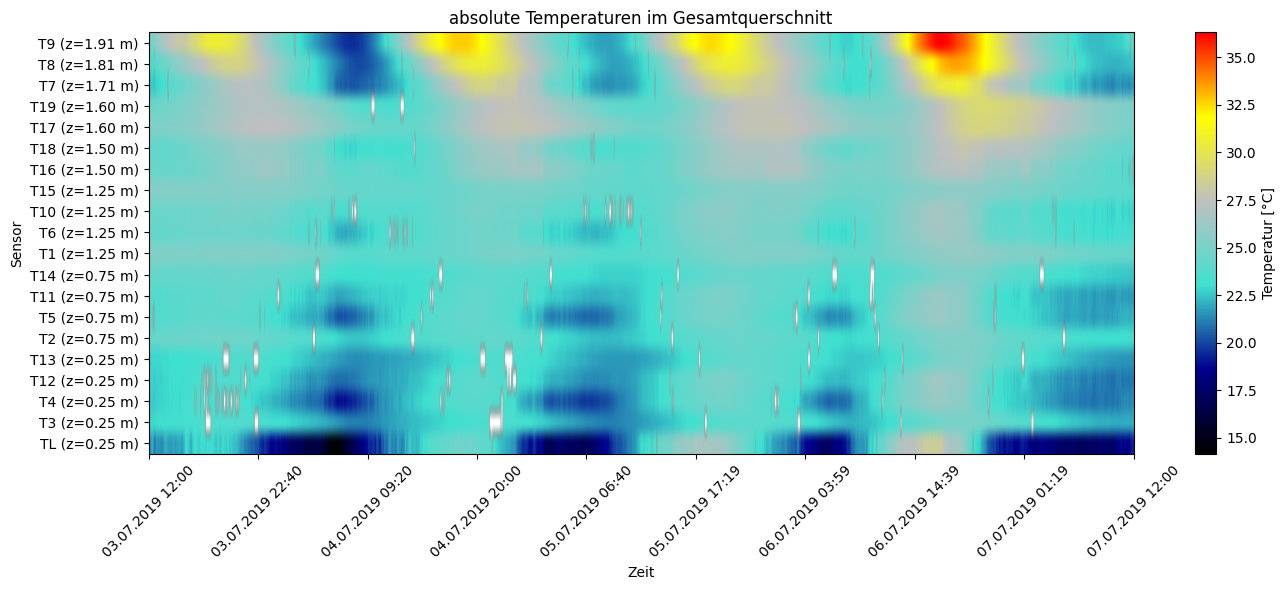

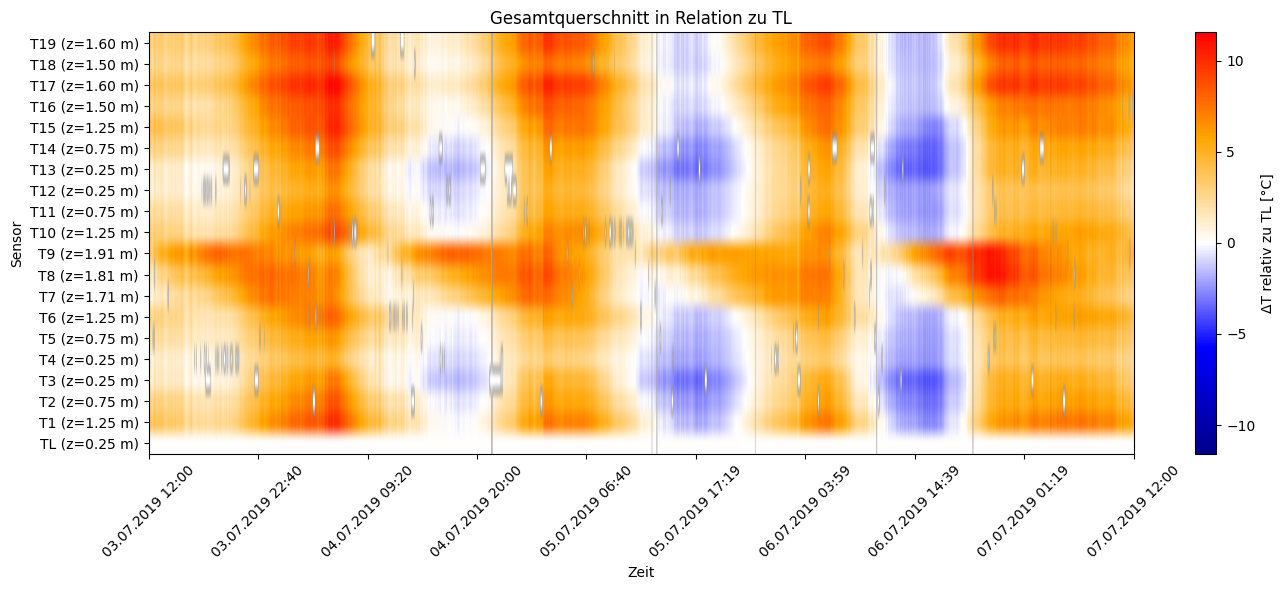

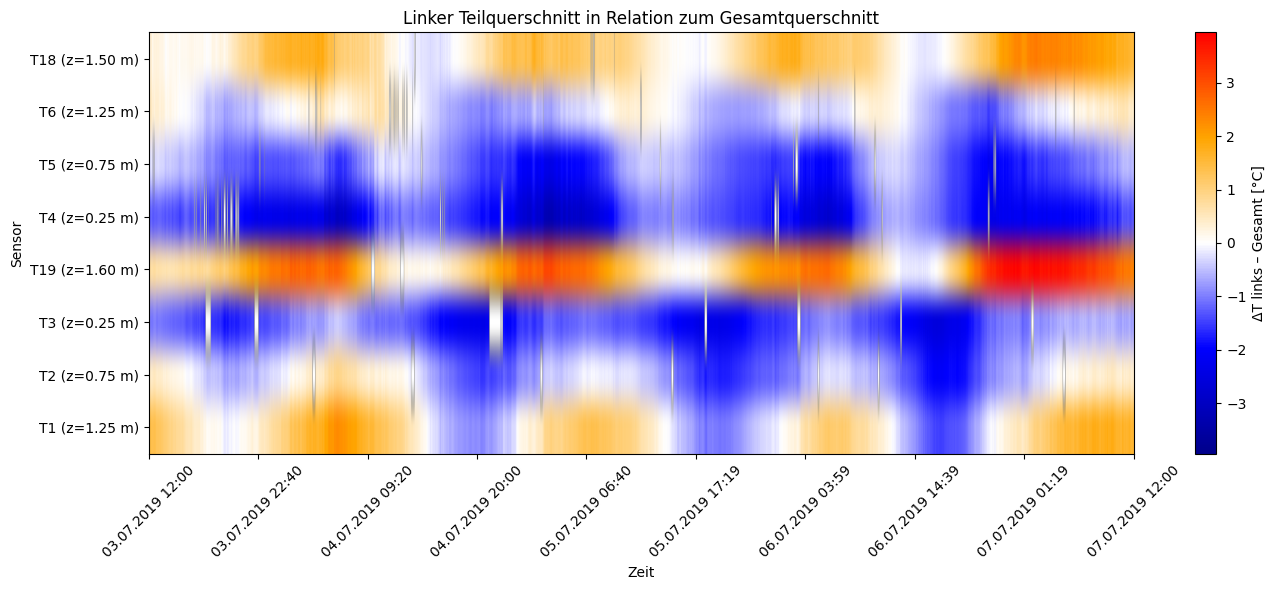

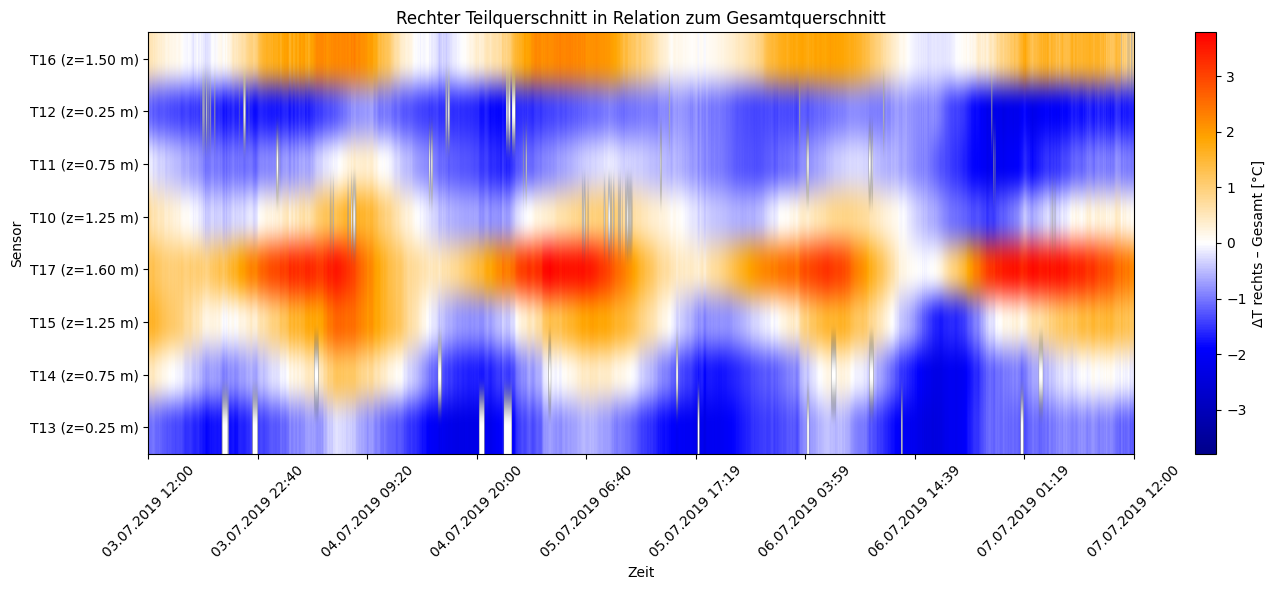

In [8]:
# Heatmaps zu Gesamt- und Teilquerschnitt
# absolut und relativ
plot_temperatur_heatmap("2019-07-03 12:00", "2019-07-07  12:00")

In [11]:
def temperaturgradient(start, ende):
    
    # ---------------------------------------
    # Daten laden (Skizzenbezeichnung)
    # ---------------------------------------
    df_skizze = lade_df(sensoren_gesamt, start, ende)

    grad_gesamt_ohneOben  = berechne_gradient(df_skizze, sensoren_gesamt_ohneOben)
    grad_links   = berechne_gradient(df_skizze, sensoren_links)
    grad_rechts  = berechne_gradient(df_skizze, sensoren_rechts)
    grad_aussen  = berechne_gradient(df_skizze, sensoren_aussen)
    grad_innen   = berechne_gradient(df_skizze, sensoren_innen)
    grad_oben    = berechne_gradient(df_skizze, sensoren_oben)

    grad_links_innen   = berechne_gradient(df_skizze, sensoren_links_innen)
    grad_links_aussen  = berechne_gradient(df_skizze, sensoren_links_aussen)
    grad_rechts_innen   = berechne_gradient(df_skizze, sensoren_rechts_innen)
    grad_rechts_aussen  = berechne_gradient(df_skizze, sensoren_rechts_aussen)
    
    # PLOT 1 - ÜBERBLICK
    plt.figure(figsize=(14, 5))
    plt.plot(
        grad_gesamt_ohneOben,
        color="silver",
        linewidth=2.2,
        label="Gradient gesamt"
    )
    
    plt.plot(
        grad_links,
        color="red",
        linewidth=1.6,
        label="Gradient links"
    )
    
    plt.plot(
        grad_rechts,
        color="darkred",
        linewidth=1.6,
        label="Gradient rechts"
    )

    plt.plot(
        grad_innen,
        linestyle=":",
        color="blue",
        linewidth=1.6,
        label="Gradient innen"
    )

    plt.plot(
        grad_aussen,
        linestyle=":",
        color="darkblue",
        linewidth=1.6,
        label="Gradient außen"
    )
    
    plt.axhline(0, color="grey", linewidth=0.8)

    plt.ylabel("Temperaturgradient dT/dz [K/m]")
    plt.xlabel("Zeit")
    plt.title("Übersicht der Temperaturgradienten (ohne TL und obere Sensoren)")
    plt.grid(True)
    plt.legend(ncol=2)
    plt.tight_layout()
    plt.show()

    # PLOT 2 - LINKS
    plt.figure(figsize=(14, 5))
    plt.plot(
        grad_gesamt_ohneOben,
        color="silver",
        linewidth=2.2,
        label="Gradient gesamt"
    )
    
    plt.plot(
        grad_links,
        color="red",
        linewidth=1.6,
        label="Gradient links"
    )

    plt.plot(
        grad_links_innen,
        color="steelblue",
        linewidth=1.6,
        label="Gradient links innen"
    )

    plt.plot(
        grad_links_aussen,
        color="skyblue",
        linewidth=1.6,
        label="Gradient links außen"
    )
    
    plt.axhline(0, color="grey", linewidth=0.8)

    plt.ylabel("Temperaturgradient dT/dz [K/m]")
    plt.xlabel("Zeit")
    plt.title("Rechter Teil-QS über die Zeit")
    plt.grid(True)
    plt.legend(ncol=2)
    plt.tight_layout()
    plt.show()

    # PLOT 3 - RECHTS
    plt.figure(figsize=(14, 5))
    plt.plot(
        grad_gesamt_ohneOben,
        color="silver",
        linewidth=2.2,
        label="Gradient gesamt"
    )
    
    plt.plot(
        grad_rechts,
        color="darkred",
        linewidth=1.6,
        label="Gradient rechts"
    )

    plt.plot(
        grad_rechts_innen,
        color="steelblue",
        linewidth=1.6,
        label="Gradient rechts innen"
    )

    plt.plot(
        grad_rechts_aussen,
        color="skyblue",
        linewidth=1.6,
        label="Gradient rechts außen"
    )
    
    plt.axhline(0, color="grey", linewidth=0.8)

    plt.ylabel("Temperaturgradient dT/dz [K/m]")
    plt.xlabel("Zeit")
    plt.title("Linker Teil-QS über die Zeit")
    plt.grid(True)
    plt.legend(ncol=2)
    plt.tight_layout()
    plt.show()

    # PLOT 4 - OBEN
    plt.figure(figsize=(14, 5))
    plt.plot(
        grad_gesamt_ohneOben,
        color="silver",
        linewidth=2.2,
        label="Gradient gesamt"
    )
    
    plt.plot(
        grad_oben,
        linestyle="--",
        color="gold",
        linewidth=1.6,
        label="Gradient oben"
    )

    plt.axhline(0, color="grey", linewidth=0.8)

    plt.ylabel("Temperaturgradient dT/dz [K/m]")
    plt.xlabel("Zeit")
    plt.title("obere Platte über die Zeit")
    plt.grid(True)
    plt.legend(ncol=2)
    plt.tight_layout()
    plt.show()  


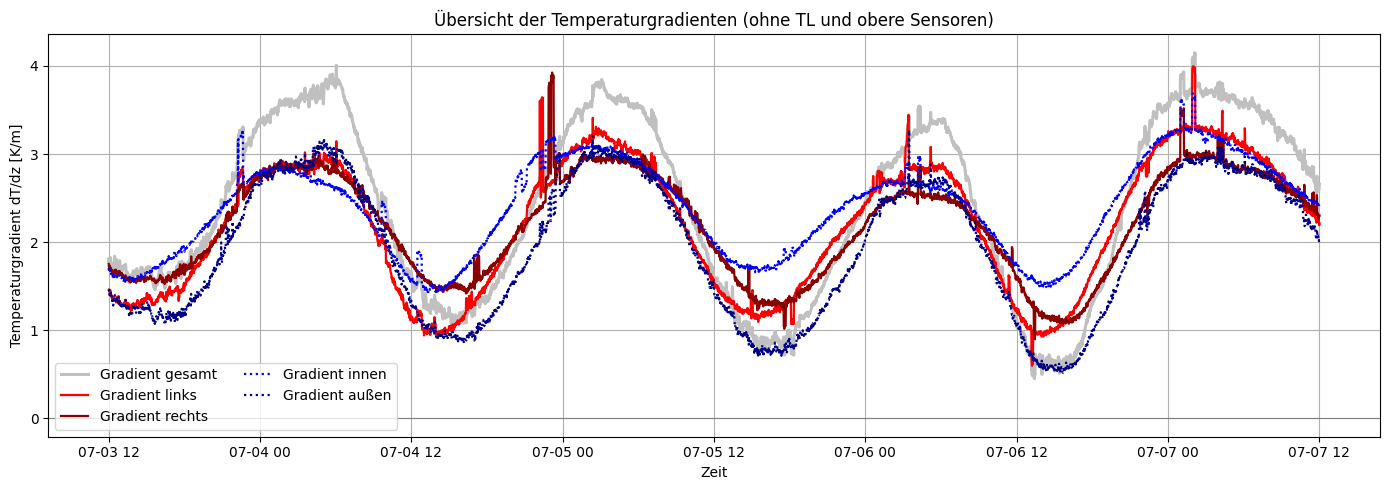

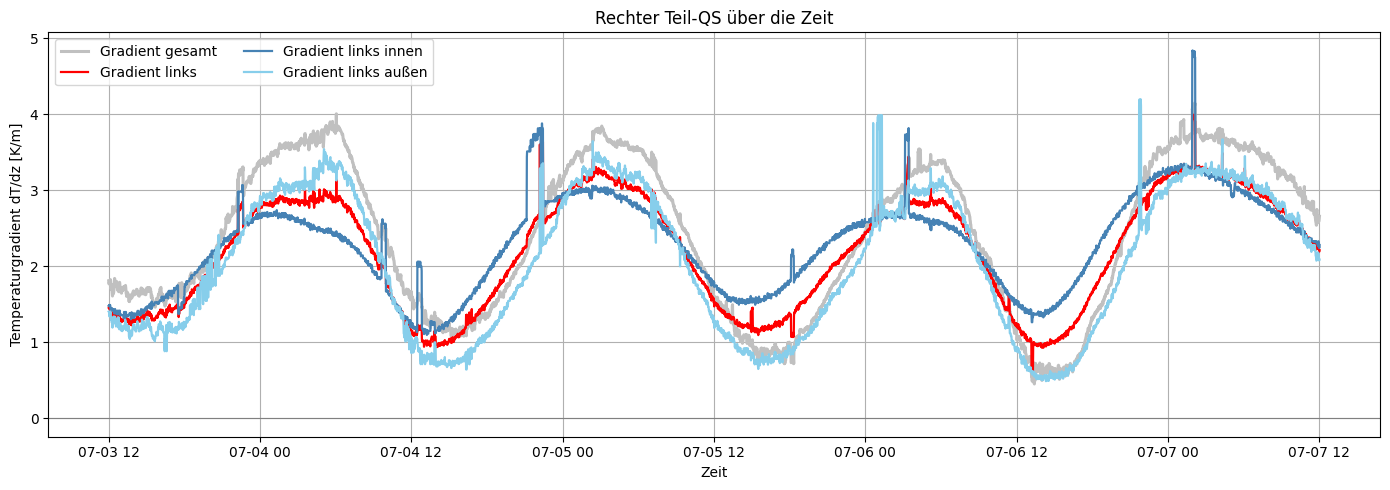

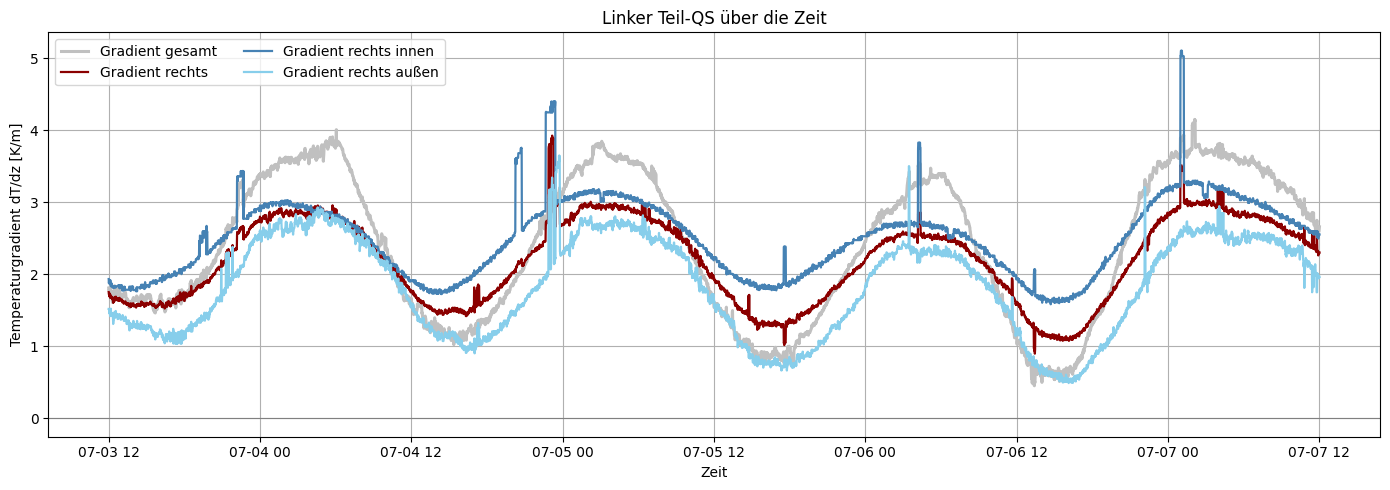

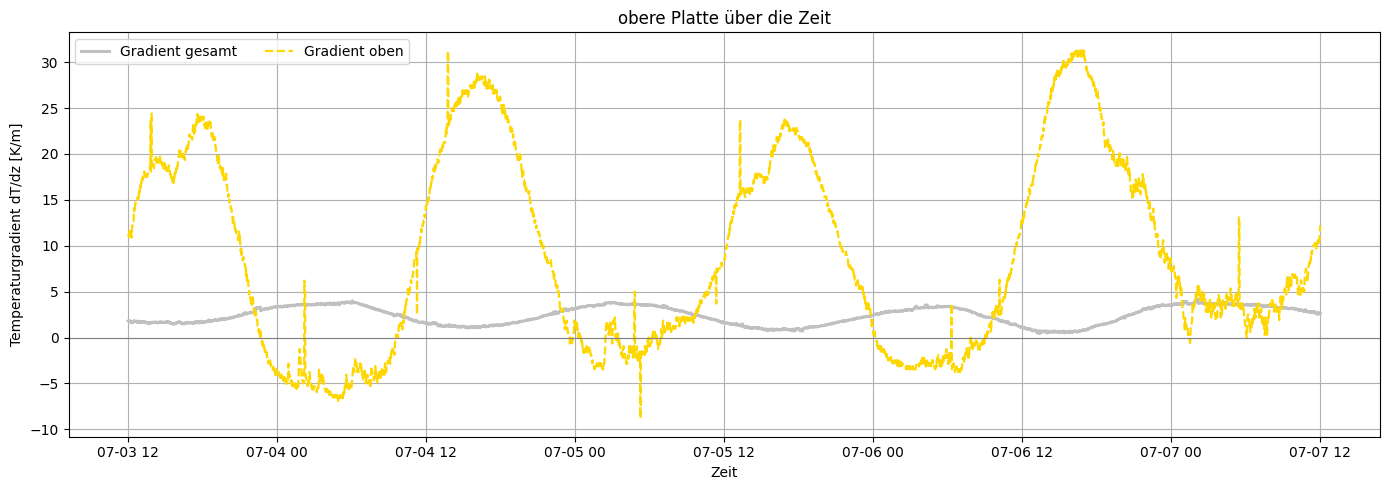

In [12]:
temperaturgradient("2019-07-03 12:00", "2019-07-07  12:00")